In [181]:
import torch
import numpy as np
import pandas as pd
import json
import os
from transformers import pipeline
from datetime import datetime as dt
from torch.utils.data import Dataset
from tqdm import tqdm

In [187]:
import datetime
from pytz import timezone

bot_accounts = pd.concat([pd.read_csv('data/social_spambots_1.csv'), pd.read_csv('data/social_spambots_2.csv'), pd.read_csv('data/social_spambots_3.csv')]).reset_index(drop=True)
clean_accounts = pd.read_csv('data/geniune_accounts.csv')

requiredColumns = ['screen_name', 'created_at', 'updated', 'location', 'verified', 'statuses_count', 'friends_count','followers_count', 'favourites_count', 'default_profile_image', 'profile_use_background_image', 'protected', 'default_profile']
bot_accounts = bot_accounts#[requiredColumns]
clean_accounts = clean_accounts#[requiredColumns]

def clean_df(df):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['updated'] = pd.to_datetime(df['updated'])
    #print(df['updated'])
    #print()
    #print(df['created_at'])
    df['age'] = ((df['updated'].dt.tz_localize('UTC') - df['created_at']) / np.timedelta64(1, 'D')).astype('int') #modified this line from original repo code.
    #df['age'] = (df['updated'].dt.tz_localize('UTC') - df['created_at']).astype('timedelta64[D]').astype(int)
    #print(df['age'])
    df['has_location'] = df['location'].apply(lambda x: 0 if x==x else 1)
    df['has_avatar'] = df['default_profile_image'].apply(lambda x: 1 if x==x else 0)
    df['has_background'] = df['profile_use_background_image'].apply(lambda x: 1 if x==x else 0)
    df['is_verified']=df['verified'].apply(lambda x: 1 if x==x else 0)
    df['is_protected']=df['protected'].apply(lambda x: 1 if x==x else 0)
    df['profile_modified'] = df['default_profile'].apply(lambda x: 0 if x==x else 1)

    #properties=['protected','geo_enabled','verified','contributors_enabled','is_translator','is_translation_enabled','profile_background_tile','profile_use_background_image','has_extended_profile','default_profile','default_profile_image']
    
    return df[['screen_name', 'age', 'has_location', 'is_verified', 'statuses_count', 'friends_count', 'followers_count', 'favourites_count', 'has_avatar', 'has_background', 'is_protected', 'profile_modified', 'protected', 'geo_enabled','verified','contributors_enabled','is_translator','profile_background_tile','profile_use_background_image','default_profile','default_profile_image', 'description']]

bot_accounts = clean_df(bot_accounts)
clean_accounts = clean_df(clean_accounts)

bot_accounts['BotOrNot'] = 1
clean_accounts['BotOrNot'] = 0

combined_df = pd.concat([bot_accounts, clean_accounts], ignore_index=True)

C:\Users\lukez\AppData\Local\Temp\ipykernel_31576\4132212342.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'])
C:\Users\lukez\AppData\Local\Temp\ipykernel_31576\4132212342.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'])


In [188]:
bot_accounts.head()

,screen_name,age,has_location,is_verified,statuses_count,friends_count,followers_count,favourites_count,has_avatar,has_background,...,geo_enabled,verified,contributors_enabled,is_translator,profile_background_tile,profile_use_background_image,default_profile,default_profile_image,description,BotOrNot
0,davideb66,2555,1,0,1299,40,22,1,1,1,...,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1
1,ElisaDospina,2521,0,0,18665,3442,12561,16358,0,1,...,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,Autrice del libro #unavitatuttacurve dal 9 apr...,1
2,Vladimir65,2497,0,0,22987,755,600,14,0,1,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,[Live Long and Prosper],1
3,RafielaMorales,2435,0,0,7975,350,398,11,0,1,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,"Cuasi Odontologa*♥,#Bipolar, #Sarcastica & Som...",1
4,FabrizioC_c,2413,0,0,20218,405,413,162,0,1,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,"I shall rise from my own death, to avenge hers...",1


In [189]:
clean_accounts.head()

,screen_name,age,has_location,is_verified,statuses_count,friends_count,followers_count,favourites_count,has_avatar,has_background,...,geo_enabled,verified,contributors_enabled,is_translator,profile_background_tile,profile_use_background_image,default_profile,default_profile_image,description,BotOrNot
0,0918Bask,1008,0,0,2177,332,208,265,0,0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15years ago X.Lines24,0
1,1120Roll,672,0,0,2660,485,330,3972,0,1,...,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,保守見習い地元大好き人間。 経済学、電工、仏教を勉強中、ちなDeではいかんのか？ (*^◯^*),0
2,14KBBrown,1776,1,0,1254,177,166,1185,0,1,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,Let me see what your best move is!,0
3,wadespeters,2006,0,0,202968,981,2248,60304,0,1,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,20. menna: #farida #nyc and the 80s actually y...,0
4,191a5bd05da04dc,403,0,0,82,79,21,5,0,1,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,Cosmetologist,0


In [190]:
combined_df.shape[0]

8386

In [191]:
combined_df["followers_count"][0]

22

In [197]:
def load_labels1(df, root='./Data/', save=True, device='cpu'):
    print('Loading labels...',end='   ')
    path=root+'label.pt'
    if not os.path.exists(path):
        labels=torch.LongTensor(df['BotOrNot']).to(device)
        if save:
            torch.save(labels,'./Data/label.pt')
    else:
        labels=torch.load(root+"label.pt").to(device)
    print('Finished')
    
    return labels

In [199]:
def Des_Preprocess1(df, root='./Data/', save=True, device='cpu'):
    print('Loading raw feature1...',end='   ')
    path=root+'description.npy'
    if not os.path.exists(path):
        description=[]
        for i in range (df.shape[0]):
            if df['description'][i] is None:
                description.append('None')
            else:
                description.append(df['description'][i])
        description=np.array(description)
        if save:
            np.save(path,description)
    else:
        description=np.load(path,allow_pickle=True)
    print('Finished')
    return description

def Des_embbeding1(root='./Data/', save=True, device='cpu'):
    print('Running feature1 embedding')
    path=root+"des_tensor.pt"
    if not os.path.exists(path):
        description=np.load(root+'description.npy',allow_pickle=True)
        print('Loading RoBerta')
        feature_extraction = pipeline('feature-extraction', model="distilroberta-base", tokenizer="distilroberta-base",device=0)
        des_vec=[]
        #for (j,each) in tqdm(enumerate(description)):
        for each in tqdm(description):
            feature=torch.Tensor(feature_extraction(each))
            for (i,tensor) in enumerate(feature[0]):
                if i==0:
                    feature_tensor=tensor
                else:
                    feature_tensor+=tensor
            feature_tensor/=feature.shape[1]
            des_vec.append(feature_tensor)
            #if (j%1000==0):
                #print('[{:>6d}/229580]'.format(j+1))
        des_tensor=torch.stack(des_vec,0).to(device)
        if save:
            torch.save(des_tensor,'./Data/des_tensor.pt')
    else:
        des_tensor=torch.load(root+"des_tensor.pt").to(device)
    print('Finished')
    return des_tensor

In [201]:
def tweets_preprocess1(df, root='./Data/', save=True, device='cpu'):
    print('Loading raw feature2...',end='   ')
    path=root+'tweets.npy'
    if not os.path.exists(path):
        tweets=[]
        for i in range(df.shape[0]):
            one_usr_tweets=[]
            one_usr_tweets.append('')
            tweets.append(one_usr_tweets)
        tweets=np.array(tweets)
        if save:
            np.save(path,tweets)
    else:
        tweets=np.load(path,allow_pickle=True)
    print('Finished')
    return tweets

In [203]:
def tweets_embedding1(root='./Data/', save=True, device='cpu'):
    print('Running feature2 embedding')
    path=root+"tweets_tensor.pt"
    if not os.path.exists(path):
        tweets=np.load("./Data/tweets.npy",allow_pickle=True)
        print('Loading RoBerta')
        feature_extract=pipeline('feature-extraction',model='roberta-base',tokenizer='roberta-base',device=0,padding=True, truncation=True,max_length=500, add_special_tokens = True)
        print("pipeline Done")
        tweets_list=[]
        for each_person_tweets in tqdm(tweets):
            for j,each_tweet in enumerate(each_person_tweets):
                print("j:", j)
                each_tweet_tensor=torch.tensor(feature_extract(each_tweet))
                for k,each_word_tensor in enumerate(each_tweet_tensor[0]):
                    if k==0:
                        total_word_tensor=each_word_tensor
                    else:
                        total_word_tensor+=each_word_tensor
                total_word_tensor/=each_tweet_tensor.shape[1]
                if j==0:
                    total_each_person_tweets=total_word_tensor
                else:
                    total_each_person_tweets+=total_word_tensor
            total_each_person_tweets/=len(each_person_tweets)
            tweets_list.append(total_each_person_tweets)
            #if (i%500==0):
                #print('[{:>6d}/229580]'.format(i+1))
        tweet_tensor=torch.stack(tweets_list).to(device)
        if save:
            torch.save(tweet_tensor,path)
    else:
        tweets_tensor=torch.load(root+"tweets_tensor.pt").to(device)
    print('Finished')
    return tweets_tensor

In [205]:
def num_prop_preprocess1(df, root='./Data/', save=True, device='cpu'):
    print('Processing feature3...',end='   ')
    path0=root+'num_properties_tensor.pt'
    if not os.path.exists(path0):
        path=root
        if not os.path.exists(path+"followers_count.pt"):
            followers_count=[]
            for i in range(df.shape[0]):
                if  df['followers_count'][i] is None:
                    followers_count.append(0)
                else:
                    followers_count.append(df['followers_count'][i])
            followers_count=torch.tensor(np.array(followers_count,dtype=np.float32)).to(device)
            if save:
                torch.save(followers_count,path+"followers_count.pt")
        
            friends_count=[]
            for i in range (df.shape[0]):
                if  df['friends_count'][i] is None:
                    friends_count.append(0)
                else:
                    friends_count.append(df['friends_count'][i])
            friends_count=torch.tensor(np.array(friends_count,dtype=np.float32)).to(device)
            if save:
                torch.save(friends_count,path+'friends_count.pt')
        
            screen_name_length=[]
            for i in range (df.shape[0]):
                if  df['screen_name'][i] is None:
                    screen_name_length.append(0)
                else:
                    screen_name_length.append(len(df['screen_name'][i]))
            screen_name_length=torch.tensor(np.array(screen_name_length,dtype=np.float32)).to(device)
            if save:
                torch.save(screen_name_length,path+'screen_name_length.pt')
        
            favourites_count=[]
            for i in range (df.shape[0]):
                if  df['favourites_count'][i] is None:
                    favourites_count.append(0)
                else:
                    favourites_count.append(df['favourites_count'][i])
            favourites_count=torch.tensor(np.array(favourites_count,dtype=np.float32)).to(device)
            if save:
                torch.save(favourites_count,path+'favourites_count.pt')
            
            active_days=[]
            for i in range (df.shape[0]):
                if  df['age'][i] is None:
                    active_days.append(0)
                else:
                    active_days.append(df['age'][i])
            active_days=torch.tensor(np.array(active_days,dtype=np.float32)).to(device)
            if save:
                torch.save(active_days,path+'active_days.pt')
            
            statuses_count=[]
            for i in range (df.shape[0]):
                if  df['statuses_count'][i] is None:
                    statuses_count.append(0)
                else:
                    statuses_count.append(int(df['statuses_count'][i]))
            statuses_count=torch.tensor(np.array(statuses_count,dtype=np.float32)).to(device)
            if save:
                torch.save(statuses_count,path+'statuses_count.pt')
            
        else:
            active_days=torch.load(path+"active_days.pt")
            screen_name_length=torch.load(path+"screen_name_length.pt")
            favourites_count=torch.load(path+"favourites_count.pt")
            followers_count=torch.load(path+"followers_count.pt")
            friends_count=torch.load(path+"friends_count.pt")
            statuses_count=torch.load(path+"statuses_count.pt")
        
        active_days=pd.Series(active_days.to('cpu').detach().numpy())
        active_days=(active_days-active_days.mean())/active_days.std()
        active_days=torch.tensor(np.array(active_days))

        screen_name_length=pd.Series(screen_name_length.to('cpu').detach().numpy())
        screen_name_length_days=(screen_name_length-screen_name_length.mean())/screen_name_length.std()
        screen_name_length_days=torch.tensor(np.array(screen_name_length_days))

        favourites_count=pd.Series(favourites_count.to('cpu').detach().numpy())
        favourites_count=(favourites_count-favourites_count.mean())/favourites_count.std()
        favourites_count=torch.tensor(np.array(favourites_count))

        followers_count=pd.Series(followers_count.to('cpu').detach().numpy())
        followers_count=(followers_count-followers_count.mean())/followers_count.std()
        followers_count=torch.tensor(np.array(followers_count))

        friends_count=pd.Series(friends_count.to('cpu').detach().numpy())
        friends_count=(friends_count-friends_count.mean())/friends_count.std()
        friends_count=torch.tensor(np.array(friends_count))

        statuses_count=pd.Series(statuses_count.to('cpu').detach().numpy())
        statuses_count=(statuses_count-statuses_count.mean())/statuses_count.std()
        statuses_count=torch.tensor(np.array(statuses_count))

        #print("followers_count shape:", followers_count.shape)
        #print("friends_count shape:", friends_count.shape)
        #print("favourites_count shape:", favourites_count.shape)
        #print("statuses_count shape:", statuses_count.shape)
        #print("screen_name_length_days shape:", screen_name_length_days.shape)
        #print("active_days shape:", active_days.shape)
        #num_properties_tensor=torch.cat([followers_count,active_days,screen_name_length,following_count,statues],dim=1)
        num_prop=torch.cat((followers_count.reshape([df.shape[0],1]),
                            active_days.reshape([df.shape[0],1]),
                            screen_name_length_days.reshape([df.shape[0],1]),
                            friends_count.reshape([df.shape[0],1]),
                            statuses_count.reshape([df.shape[0],1])),1).to(device)

        
        #num_prop=torch.cat((followers_count.reshape([df.shape[0],1]),friends_count.reshape([df.shape[0],1]),favourites_count.reshape([df.shape[0],1]),statuses_count.reshape([df.shape[0],1]),screen_name_length_days.reshape([df.shape[0],1]),active_days.reshape([df.shape[0],1])),1).to(device)

        if save:
            torch.save(num_prop,"./Data/num_prop.pt")
        
    else:
        num_prop=torch.load(root+"num_properties_tensor.pt").to(device)
    print('Finished')
    return num_prop

In [207]:
def cat_prop_preprocess1(df, root='./Data/', save=True, device='cpu'):
    print('Processing feature4...',end='   ')
    path=root+'cat_properties_tensor.pt'
    if not os.path.exists(path):
        category_properties=[]
        #properties=['protected','geo_enabled','verified','contributors_enabled','is_translator','is_translation_enabled','profile_background_tile','profile_use_background_image','has_extended_profile','default_profile','default_profile_image']
        properties=['default_profile_image']
        for i in range (df.shape[0]):
            prop=[]
            for each in properties:
                if each == 'is_translation_enabled' or each == 'has_extended_profile':
                    prop.append(0)
                else:
                    if df[each][i] is None:
                        prop.append(0)
                    else:
                        if df[each][i] == 1:
                            prop.append(1)
                        else:
                            prop.append(0)
            prop=np.array(prop)
            category_properties.append(prop)
        category_properties=torch.tensor(np.array(category_properties,dtype=np.float32)).reshape([df.shape[0],1]).to(device)
        if save:
            torch.save(category_properties,root+'category_properties.pt')
    else:
        category_properties=torch.load(root+"cat_properties_tensor.pt").to(device)
    print('Finished')
    return category_properties

In [209]:
def Build_Graph1(root='./Data/', save=True, device='cpu'):
        print('Building graph',end='   ')
        path=root+'edge_index0.pt'
        if not os.path.exists(path):
            edge_index=torch.empty(2, 0)
            edge_type=[]
            #edge_index.append(0,0)
            #edge_index.append([[],[]])
            edge_index=torch.tensor(edge_index,dtype=torch.long).t().contiguous().to(device)
            edge_type=torch.tensor(edge_type,dtype=torch.long).to(device)
            if save:
                torch.save(edge_index,root+"edge_index.pt")
                torch.save(edge_type,root+"edge_type.pt")
        else:
            edge_index=torch.load(root+"edge_index.pt").to(device)
            edge_type=torch.load(root+"edge_type.pt").to(device)
            print('Finished')
        return edge_index,edge_type

In [211]:
labels=load_labels1(combined_df)
print(labels.shape)

Loading labels...   Finished
torch.Size([8386])


In [213]:
Des_Preprocess1(combined_df)
des_tensor=Des_embbeding1()

Loading raw feature1...   Finished
Running feature1 embedding
Finished


In [215]:
tweets_preprocess1(combined_df)
tweets_tensor=tweets_embedding1()

Loading raw feature2...   Finished
Running feature2 embedding
Finished


In [217]:
num_prop=num_prop_preprocess1(combined_df)
print(num_prop.shape)

#num_prop1=num_prop_preprocess1(combined_df)
#print(num_prop1.shape)

Processing feature3...   Finished
torch.Size([8386, 5])


In [219]:
category_prop=cat_prop_preprocess1(combined_df)

Processing feature4...   Finished


In [221]:
edge_index,edge_type=Build_Graph1()
edge_index=torch.empty(2, 0).type(torch.int)
print(edge_index)
print(edge_type)

Building graph   tensor([], size=(2, 0), dtype=torch.int32)
tensor([], dtype=torch.int64)


C:\Users\lukez\AppData\Local\Temp\ipykernel_31576\3405911823.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index=torch.tensor(edge_index,dtype=torch.long).t().contiguous().to(device)


In [274]:
index = []
for i in range(num_prop.shape[0]):
    #print(i)
    index.append(i)

index_tens = torch.tensor(index) 
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Split the dataset into training and validation sets
train_idx, val_idx = train_test_split(index_tens, test_size=0.15, random_state=42)

# Further split the training set into training and test sets
train_idx, test_idx = train_test_split(index_tens, test_size=0.15 / 0.85, random_state=42)
print(train_idx)
print(val_idx)
print(test_idx)
print(index_tens.shape)
print(index_tens)


tensor([1626, 7069,  624,  ..., 5390,  860, 7270])
tensor([2865, 8178, 5934,  ..., 7346, 7640,   73])
tensor([2865, 8178, 5934,  ..., 8289, 5296,  847])
torch.Size([8386])
tensor([   0,    1,    2,  ..., 8383, 8384, 8385])


Text(0.5, 1.0, 'Ratio of training data')

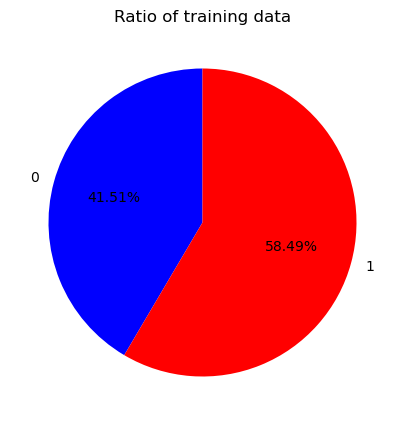

In [336]:
import matplotlib.pyplot as plt
import seaborn as sns
outputs_test = labels[train_idx].tolist()
botlable = 0
personlable = 0
for lable in outputs_test:
    if lable:
        botlable +=1
    else:
        personlable +=1
#print("botlable:", botlable+ personlable)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels1 = {0, 1}
sizes = [personlable, botlable]

fig1, ax1 = plt.subplots(figsize = (5,5))
ax1.pie(sizes, labels=labels1, autopct='%1.2f%%', 
        startangle=90,
        colors=['b','r'])

#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

text =  'Ratio of training data'
ax1.set_title(text)

Text(0.5, 1.0, 'Ratio of val data')

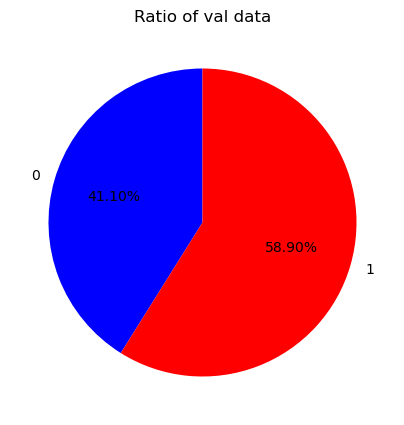

In [338]:
import matplotlib.pyplot as plt
import seaborn as sns
outputs_test = labels[val_idx].tolist()
botlable = 0
personlable = 0
for lable in outputs_test:
    if lable:
        botlable +=1
    else:
        personlable +=1
#print("botlable:", botlable+ personlable)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels1 = {0, 1}
sizes = [personlable, botlable]

fig1, ax1 = plt.subplots(figsize = (5,5))
ax1.pie(sizes, labels=labels1, autopct='%1.2f%%', 
        startangle=90,
        colors=['b','r'])

#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

text =  'Ratio of val data'
ax1.set_title(text)

Text(0.5, 1.0, 'Ratio of testing data')

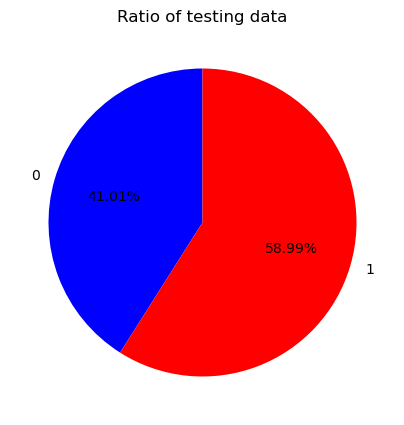

In [340]:
import matplotlib.pyplot as plt
import seaborn as sns
outputs_test = labels[test_idx].tolist()
botlable = 0
personlable = 0
for lable in outputs_test:
    if lable:
        botlable +=1
    else:
        personlable +=1
#print("botlable:", botlable+ personlable)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels1 = {0, 1}
sizes = [personlable, botlable]

fig1, ax1 = plt.subplots(figsize = (5,5))
ax1.pie(sizes, labels=labels1, autopct='%1.2f%%', 
        startangle=90,
        colors=['b','r'])

#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

text =  'Ratio of testing data'
ax1.set_title(text)

In [492]:
import torch
from torch import nn
from torch_geometric.nn import RGCNConv,FastRGCNConv,GCNConv,GATConv
import torch.nn.functional as F

class BotRGCN(nn.Module):
    def __init__(self,des_size=768,tweet_size=768,num_prop_size=5,cat_prop_size=3,embedding_dimension=128,dropout=0.3):
        super(BotRGCN, self).__init__()
        self.dropout = dropout
        self.linear_relu_des=nn.Sequential(
            nn.Linear(des_size,int(embedding_dimension/4)),
            nn.LeakyReLU()
        )
        self.linear_relu_tweet=nn.Sequential(
            nn.Linear(tweet_size,int(embedding_dimension/4)),
            nn.LeakyReLU()
        )
        self.linear_relu_num_prop=nn.Sequential(
            nn.Linear(num_prop_size,int(embedding_dimension/4)),
            nn.LeakyReLU()
        )
        self.linear_relu_cat_prop=nn.Sequential(
            nn.Linear(cat_prop_size,int(embedding_dimension/4)),
            nn.LeakyReLU()
        )
        
        self.linear_relu_input=nn.Sequential(
            nn.Linear(embedding_dimension,embedding_dimension),
            nn.LeakyReLU()
        )
        
        self.rgcn=RGCNConv(embedding_dimension,embedding_dimension,num_relations=2)
        
        self.linear_relu_output1=nn.Sequential(
            nn.Linear(embedding_dimension,embedding_dimension),
            nn.LeakyReLU()
        )
        self.linear_output2=nn.Linear(embedding_dimension,2)
        
        
        
    def forward(self,des,tweet,num_prop,cat_prop,edge_index,edge_type):
        d=self.linear_relu_des(des)
        t=self.linear_relu_tweet(tweet)
        n=self.linear_relu_num_prop(num_prop)
        c=self.linear_relu_cat_prop(cat_prop)
        x=torch.cat((d,t,n,c),dim=1)
        
        x=self.linear_relu_input(x)
        x=self.rgcn(x,edge_index,edge_type)
        x=F.dropout(x,p=self.dropout,training=self.training)
        x=self.rgcn(x,edge_index,edge_type)
        x=self.linear_relu_output1(x)
        x=self.linear_output2(x)
            
        return x
            

In [494]:
embedding_size,dropout,lr,weight_decay=32,0.1,1e-2,5e-2

model=BotRGCN(cat_prop_size=1,embedding_dimension=embedding_size).to('cpu')
loss=nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                    lr=lr,weight_decay=weight_decay)

In [496]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve,auc

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.kaiming_uniform_(m.weight)


def test(test_idx):
    model.eval()
    output = model(des_tensor,tweets_tensor,num_prop,category_prop,edge_index,edge_type)
    loss_test = loss(output[test_idx], labels[test_idx])
    acc_test = accuracy(output[test_idx], labels[test_idx])
    output=output.max(1)[1].to('cpu').detach().numpy()
    label=labels.to('cpu').detach().numpy()
    f1=f1_score(label[test_idx],output[test_idx])
    #mcc=matthews_corrcoef(label[test_idx], output[test_idx])
    precision=precision_score(label[test_idx],output[test_idx])
    recall=recall_score(label[test_idx],output[test_idx])
    fpr, tpr, thresholds = roc_curve(label[test_idx], output[test_idx], pos_label=1)
    Auc=auc(fpr, tpr)
    print("Test set results:",
            "test_loss= {:.4f}".format(loss_test.item()),
            "test_accuracy= {:.4f}".format(acc_test.item()),
            "precision= {:.4f}".format(precision.item()),
            "recall= {:.4f}".format(recall.item()),
            "f1_score= {:.4f}".format(f1.item()),
            #"mcc= {:.4f}".format(mcc.item()),
            "auc= {:.4f}".format(Auc.item()),
            )

In [498]:
model.load_state_dict(torch.load('BotRGCN_weight.pth'))

<All keys matched successfully>

In [500]:
test(index_tens)

Test set results: test_loss= 3.4906 test_accuracy= 0.5949 precision= 0.5912 recall= 0.9996 f1_score= 0.7430 auc= 0.5112


In [502]:
def train(epoch):
    model.train()
    output = model(des_tensor,tweets_tensor,num_prop,category_prop,edge_index,edge_type)
    loss_train = loss(output[train_idx], labels[train_idx])
    acc_train = accuracy(output[train_idx], labels[train_idx])
    acc_val = accuracy(output[val_idx], labels[val_idx])
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    print('Epoch: {:04d}'.format(epoch+1),
        'loss_train: {:.4f}'.format(loss_train.item()),
        'acc_train: {:.4f}'.format(acc_train.item()),
        'acc_val: {:.4f}'.format(acc_val.item()),)
    return acc_train,acc_val

In [504]:
epochs=200
acc_val_best = 0
i = 0
for epoch in range(epochs):
    acc_train,acc_val = train(epoch)
    if acc_val > acc_val_best:
        acc_val_best = acc_val
        test(index_tens)
        torch.save(model.state_dict(), "BotRGNC_AfterTrain.pth")
        i=0
    else:
        i = i+1

    if i>50:
        break

Epoch: 0001 loss_train: 3.4111 acc_train: 0.5943 acc_val: 0.6041
Test set results: test_loss= 0.5062 test_accuracy= 0.7597 precision= 0.7861 recall= 0.8103 f1_score= 0.7980 auc= 0.7493
Epoch: 0002 loss_train: 0.5527 acc_train: 0.7598 acc_val: 0.7655
Test set results: test_loss= 1.0760 test_accuracy= 0.4311 precision= 0.9608 recall= 0.0299 f1_score= 0.0580 auc= 0.5141
Epoch: 0003 loss_train: 1.1143 acc_train: 0.4356 acc_val: 0.4324
Epoch: 0004 loss_train: 0.7851 acc_train: 0.4832 acc_val: 0.4722
Epoch: 0005 loss_train: 0.5118 acc_train: 0.8249 acc_val: 0.8227
Test set results: test_loss= 0.4987 test_accuracy= 0.7676 precision= 0.7266 recall= 0.9672 f1_score= 0.8298 auc= 0.7263
Epoch: 0006 loss_train: 0.4965 acc_train: 0.7787 acc_val: 0.7750
Epoch: 0007 loss_train: 0.5148 acc_train: 0.7116 acc_val: 0.7210
Epoch: 0008 loss_train: 0.4929 acc_train: 0.7163 acc_val: 0.7321
Epoch: 0009 loss_train: 0.4484 acc_train: 0.7577 acc_val: 0.7703
Epoch: 0010 loss_train: 0.4074 acc_train: 0.7981 acc_va

In [596]:
model.load_state_dict(torch.load('BotRGNC_AfterTrain.pth'))
test(index_tens)

Test set results: test_loss= 0.0622 test_accuracy= 0.9846 precision= 0.9882 recall= 0.9855 f1_score= 0.9869 auc= 0.9844


In [622]:
model.eval()
output = model(des_tensor,tweets_tensor,num_prop,category_prop,edge_index,edge_type)
output1= torch.nn.functional.softmax(output, dim=1)[:, 1].detach().numpy()
label=labels.to('cpu').detach().numpy()

In [624]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
print(label[test_idx])
print()
print(output1[test_idx])
fpr, tpr, _ = metrics.roc_curve(label[test_idx], output1[test_idx])

[1 0 0 ... 0 0 1]

[0.99553335 0.03873624 0.01817291 ... 0.29804915 0.01739535 1.        ]


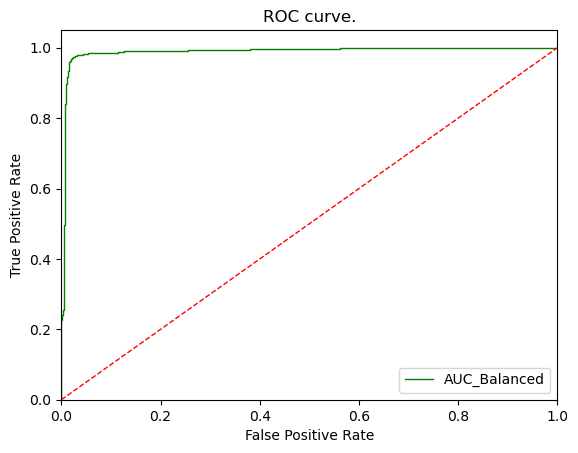

In [626]:
plt.plot(
    fpr,
    tpr,
    color= "g",
    lw=1,
    label= "AUC_Balanced",
)
plt.plot([0, 1], [0, 1], color="r", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve.")
plt.legend(loc="lower right")
plt.show()